<a href="https://colab.research.google.com/github/hcantekin/Environmental-Economics/blob/main/ExtendedGreenSolowModel-notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Green Solow Continued: Integrated Assessment Models

In [4]:
import sympy as sym
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 450
import matplotlib.pyplot as plt
!pip install --upgrade matplotlib
import math

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Introduction**

In this notebook we extend/amend the Green Solow Model from last year by (1) adding a simple Carbon Cycle to the model, where emissions have an effect on temperatures and create economic damage and (2) simplifying the abatement technology in a way that we are investing in green technology only.

**Emissions**

Emissions are simplified and are now dependent only on abatement technology. The fraction of GDP invested in abatement is $\theta$ and the effectiveness is growing over time. 

$𝑒_t = 𝐹(𝑘_t,1)\Omega_t$

$\Omega_t = (1-\omega)^t = 1-(b_1*\theta_2^{b_2})^t$

**C02 concentration in the athmosphere $M_t$**

$M_{t+1}=\beta e_t L_t - δ_M  M_t$

**Radiative Forcing relative to pre-industrial level**
            
$RF_t=RF_0+\eta log({M_t \over M_0})$

**Temperature in the atmospheric/upper-oceanic layer of the environment as a result of radiative forcings:**

$T1_{t+1} = (1-\lambda) T1_{t} + RF_{t} - D12 (T1_{t} - T2_{t})$

**Temperature in the lower oceanic layer**

$T2_{t+1} = T2_{t}+ D12 (T1_t - T2_t)$

**Damage Function: Temperature increases lead to environmental damage**

$dam_t = c_1*T1_t + c_2*(T2_2)^2$

**Capital accumulates through savings, but environmental damage makes capital investment more expensive (through damage)**

$k_{t+1} - k_t= s(1-\theta_2)(1-dam_t)*(F[k[t], 1] -(d+n_t*k_t)$


**Student Tasks**
You can click into this field and type your answers below the questions. 

**Task 1:** 'Translate' the equations above into 'plain English' and explain how emissions effect the environment and what feedback effect this has on the economic system. 

## Simulations

We now simulate the full model. The paramterisation is roughly estimated and not realistic. The aim of the model is to appreciate the model dynamics and to see how different parts of the model are linked. 

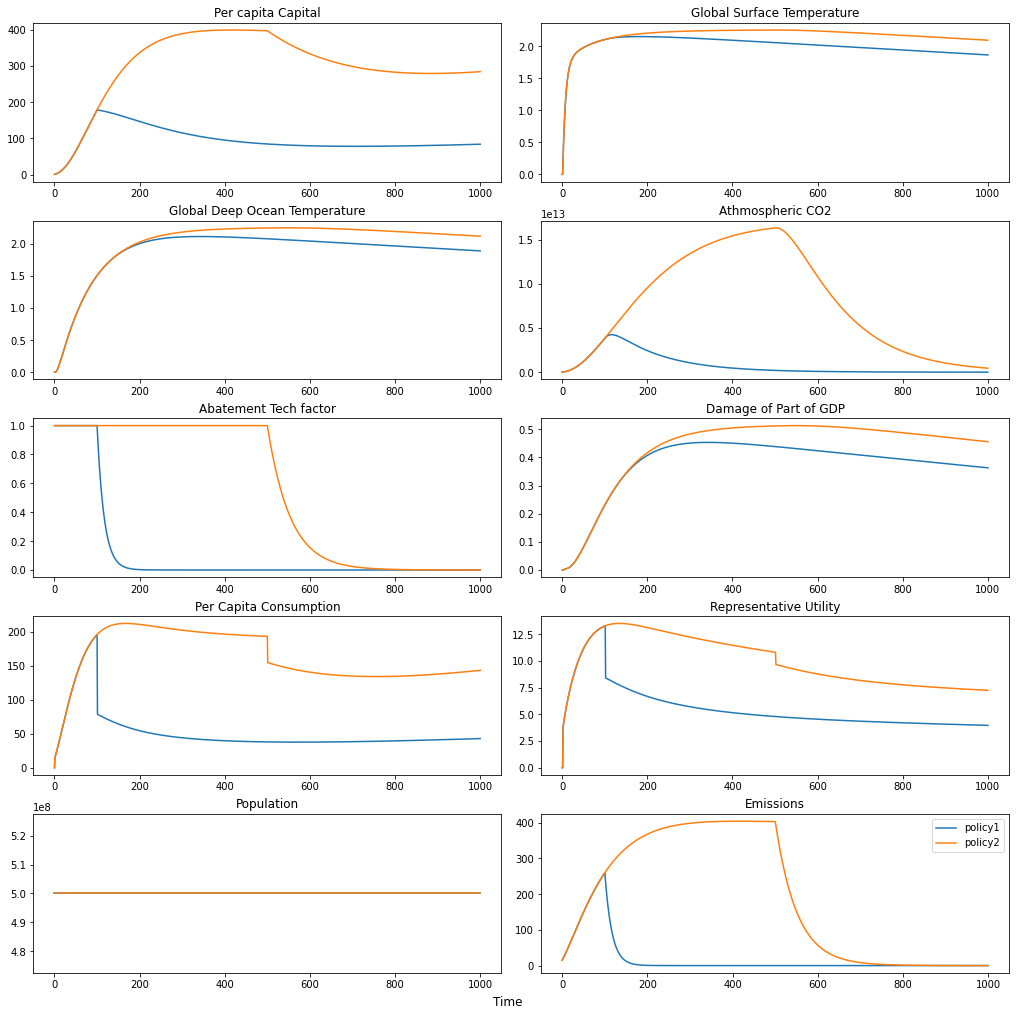

In [13]:
def simulate_the_policy(T, RF0, eta, M0, k0:float, L0, A, a, s, d, c1, c2, xi, b1, b2, beta, deltaM, lamda, D12, r, abatementp=1):

    n= 0.00 #population growth

    M = [M0]
    T1 = [0]
    T2 = [0]
    k = [k0]
    L = [L0]
    Em = []
    Omega = [1]
    dam = [0]
    Consumption = [0]
    Utility = [0]

    for t in range (T):
        
        RF = RF0 + eta * math.log(M[t]/M0) #Radiative Force
        f = A * k[t]**a #Production Function
        
           #We compare two different policies, i.e. abatement and no abatement. 
        if abatementp == 1:
            if t < 100:  # python starts numbering from 0 
             theta2=0
            else:
             theta2 = 0.6
        elif abatementp == 2:
            if t < 500:
             theta2 = 0
            else:
             theta2 = 0.2 
    
        Em.append(f*Omega[t]) #Emissions
        
        Consumption.append((1-theta2)*(1-s)*f*(1-dam[t])) #Consumption as part of GDP
        
        k.append(s*f*(1-dam[t])*(1-theta2)-(d-1+n)*k[t]) #capital accumulation 
        
        Omega.append((1-b1*theta2**b2)*Omega[t]) #Green Technology
        
        M.append(beta * L[t] * Em[t] + (1-deltaM)*M[t]) #Emissions Concentration
        
        T1.append(RF + (1-lamda)*T1[t] - D12 * (T1[t]-T2[t])) #Temperature Upper Ocean Layer
        
        T2.append(T2[t] + D12 * (T1[t]-T2[t])) #Temperature Lower Ocean Layer
        
        L.append((1+n)*L[t]) 
        
        dam.append(c1*T1[t] + c2*(T2[t]**2))
        
        Utility.append(Consumption[t]**0.5 * np.exp(-r*t))

    return k, Em, T1, T2, M, Omega, dam, Utility, Consumption, L 

# simulate and store results in dictionary

def simulate_with_result_in_dictionary(policy):
    k, Em, T1, T2, M, Omega, dam, Utility, Consumption, L = simulate_the_policy(T=1000, RF0=0, eta=0.006, M0=0.00000001, k0=1.0, L0=500000000, 
                                                               A=15, a= 0.55, s=0.02, d=0.01, c1=0.003, c2=0.1, xi=2, b1=0.1, b2=1.05, 
                                                               beta=0.7, deltaM=0.0083, lamda=0.13, D12=0.015, r=0.0005, abatementp=policy)
    results = {'k': k, 'Em': Em, 'T1':T1, 'T2':T2, 'M':M, 'Omega':Omega, 'dam':dam, 'Utility':Utility,'Consumption':Consumption, 'L':L}
    return results

results_p1 = simulate_with_result_in_dictionary(policy=1)
results_p1['policy'] = 'policy1'

results_p2 = simulate_with_result_in_dictionary(policy=2)
results_p2['policy'] = 'policy2'

# graph 

figcontents = {(0,0): ('k','Per capita Capital'), 
(0,1): ('T1', 'Global Surface Temperature'), 
(1,0): ('T2', 'Global Deep Ocean Temperature'), 
(1,1): ('M', 'Athmospheric CO2'),
(2,0): ('Omega', 'Abatement Tech factor'),
(2,1): ('dam', 'Damage of Part of GDP'),
(3,0): ('Consumption', 'Per Capita Consumption'),
(3,1): ('Utility','Representative Utility'),
(4,0): ('L','Population'),
(4,1): ('Em','Emissions')}
num_rows=5
num_cols=2

fig, axes = plt.subplots(num_rows, num_cols, constrained_layout = True, figsize=(14,14))

for i in range(num_rows):
    for j in range(num_cols):
        for results in results_p1, results_p2:
            axes[i,j].plot(results[figcontents[i,j][0]], label= results['policy'])
            axes[i,j].set(title=figcontents[i,j][1])

fig.supxlabel('Time')
plt.legend()
plt.show()

**Student Tasks**
You can click into this field and type your answers below the questions. 

**Task 2:** Discuss the simulation above. in particular, how do the two policies compare. 

**Task 3:** Are either of the policies sustainable?

**Task 4:** Investigate another policy of your choice, i.e small versus high expenditure $\theta2$ into abatement technology. Discuss your simulation.

**Task 5:** Investigate what would happen if future consumption is not discounted by changing r.

**Answer:**
Models tradeoff between consumption now and later. 
2) Plots show different outcomes for policy 1 (blue, where pheta is a positive value so we are investing some amount of output into abatement tech), and policy 2 (orange, where theta is 0 so no investment in abatement tech). So, policy 1 sees decline in emissions whereas policy 2 continues rising over time. The abatement technology factor remains constant at 1 with no investment in abatement, or declines with policy 1 where investing in abatement.  



3) If a policy is sustainable depends on definition of sustainabality, so if include utility then policy 2 might be more sustainable... policy 1 has lower utility because investing more of current output into abatement tech. Per capita capital is also higher for policy 2 as we are not investing into abatement. However, emissions and temperatures are declining/relatively lower which suggests better ecological (and socioeconomic) outcomes... So, if change baseline damage (c1) to higher number, then over time utlity of policy 1 becomes higher than for policy 2. If climate damage (c1) is small then no need to invest in abatement tech... how high climate damage is determines at what point the utlity under policy 1 (with abatement investment) overtakes policy 2. How much we invest depends on how much we care about future generations/sustainablity... and do we care more about future generations utility or do want it to be same as current utlity... a trade-off. 


4) If change theta values under if/elif conditions in code, we can see different policy outcomes for different levels of investment in abatement tech. So with policy 2 theta = 0.2, and policy 1 theta = 0.6, (check level of damage) we can see difference... 

5) What would happen if future consumption was not discounted by r? (see list of paramaters)... currently = 0.0005.

NOTES = 